<a href="https://colab.research.google.com/github/codeplinth/pytorchbootcamp/blob/master/PyTorch_30_DeepNeuralNetwork_ModuleList.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
import torchvision
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [33]:
torch.manual_seed(1)

In [34]:
# Define the function to plot the diagram
def plot_decision_regions_3class(model, data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _, yhat = torch.max(model(XX), 1)
    yhat = yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[y[:] == 0, 0], X[y[:] == 0, 1], 'ro', label = 'y=0')
    plt.plot(X[y[:] == 1, 0], X[y[:] == 1, 1], 'go', label = 'y=1')
    plt.plot(X[y[:] == 2, 0], X[y[:] == 2, 1], 'o', label = 'y=2')
    plt.title("decision region")
    plt.legend()

In [35]:
# Create Sample data Class
class Sample_Data(Dataset):
    def __init__(self, K=3, N=500):
        D = 2
        X = np.zeros((N * K, D)) # data matrix (each row = single example)
        y = np.zeros(N * K, dtype='uint8') # class labels
        for j in range(K):
          ix = range(N * j, N * (j + 1))
          r = np.linspace(0.0, 1, N) # radius
          t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
          X[ix] = np.c_[r * np.sin(t), r*np.cos(t)]
          y[ix] = j
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.x = torch.from_numpy(X).type(torch.FloatTensor)
        self.len = y.shape[0]
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len
    def plot_stuff(self):
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y = 0")
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y = 1")
        plt.plot(self.x[self.y[:] == 2, 0].numpy(), self.x[self.y[:] == 2, 1].numpy(), 'go', label="y = 2")
        plt.legend()

In [36]:
#create the neural network
class Neural_Net(nn.Module):
  def __init__(self,Layers):
    super(Neural_Net,self).__init__()
    self.layers = nn.ModuleList()
    for input_size,output_size in zip(Layers,Layers[1:]):
      self.layers.append(nn.Linear(input_size,output_size))

  def forward(self,x):
    L = len(self.layers)
    for (l,linear_transform) in zip(range(L),self.layers):
      if l < L - 1 :
        x = F.relu(linear_transform(x))
      else:
        x = linear_transform(x)
    return x

In [37]:
def train_model(model,optimizer,criterion,train_dataset,trainloader,EPOCHS):
  metrics = {'training_loss':[],'validation_accuracy':[]}
  for epoch in range(EPOCHS):
    for x,y in trainloader:
      y_pred = model(x)
      loss = criterion(y_pred,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      metrics['training_loss'].append(loss.item())
    metrics['validation_accuracy'].append(accuracy(model,train_dataset))
  fig, ax1 = plt.subplots()
  color = 'tab:red'
  ax1.plot(metrics['training_loss'], color = color)
  ax1.set_xlabel('Iteration', color = color)
  ax1.set_ylabel('Loss', color = color)
  ax1.tick_params(axis = 'y', color = color)
  
  ax2 = ax1.twinx()  
  color = 'tab:blue'
  ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
  ax2.plot(metrics['validation_accuracy'], color = color)
  ax2.tick_params(axis = 'y', color = color)
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  
  plt.show()
  return metrics

In [38]:
def accuracy(model, data_set):
    _, y_pred = torch.max(model(data_set.x), 1)
    return (y_pred == data_set.y).numpy().mean()

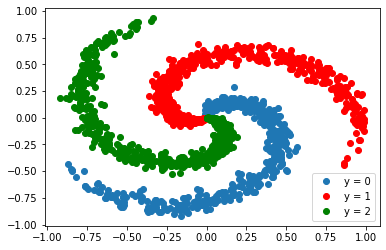

In [39]:
dataset = Sample_Data()
dataset.plot_stuff()
dataset.y = dataset.y.view(-1)

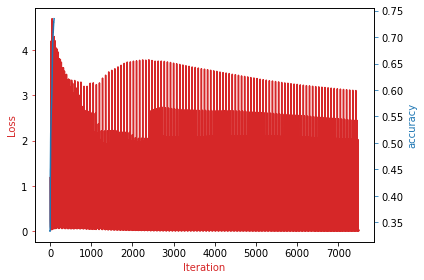

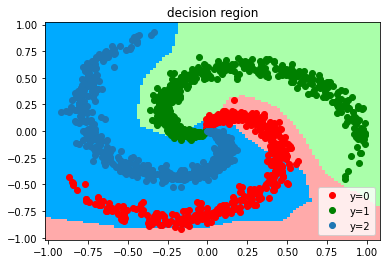

In [40]:
Layers = [2, 50, 3]
model = Neural_Net(Layers)
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(),lr = learning_rate)
criterion = nn.CrossEntropyLoss()
trainloader = DataLoader(dataset = dataset,batch_size=20)
metrics = train_model(model,optimizer,criterion,dataset,trainloader,EPOCHS=100)
plot_decision_regions_3class(model, dataset)

In [49]:
#Neural_Net([3,3,4,3]).parameters
model.parameters

<bound method Module.parameters of Neural_Net(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=3, bias=True)
  )
)>

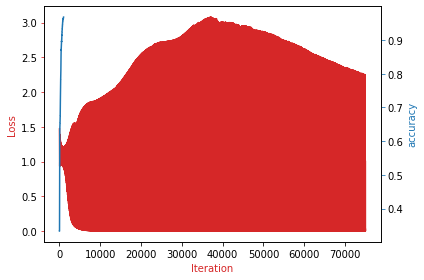

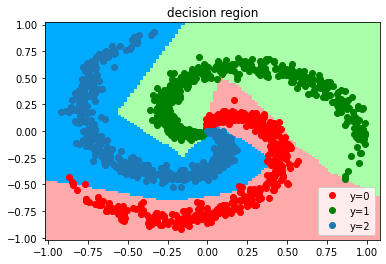

In [50]:
#model with 2 hidden layers
Layers = [2,10,10,3]
model = Neural_Net(Layers)
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(),lr = learning_rate)
criterion = nn.CrossEntropyLoss()
trainloader = DataLoader(dataset = dataset,batch_size=20)
metrics = train_model(model,optimizer,criterion,dataset,trainloader,EPOCHS=1000)
plot_decision_regions_3class(model, dataset)

In [51]:
model.parameters

<bound method Module.parameters of Neural_Net(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)>